In [8]:
import os
from typing import Optional, List, Tuple
from ultralytics import YOLO
from PIL import Image

def is_image_file(filename: str) -> bool:
    """
    Check if the file is a valid image file based on its extension.

    Args:
        filename (str): The name of the file to check.

    Returns:
        bool: True if the file has a valid image extension, False otherwise.
    """
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def run_obb_yolo_inference(
    input_dir: str,
    output_dir: str,
    model_path: str,
    imgsz: int = 640,
    conf: float = 0.50,
    save_all_obb: bool = True,
    normalize: bool = True,
    include_class_id: bool = True
) -> None:
    """
    Run YOLO inference on images in a directory and save results as text files.

    Args:
        input_dir (str): Path to the input directory containing images.
        output_dir (str): Path to the output directory where images and labels will be saved.
        model_path (str): Path to the YOLO model weights file.
        imgsz (int, optional): Image size for inference. Defaults to 640.
        conf (float, optional): Confidence threshold for predictions. Defaults to 0.50.
        save_all_obb (bool, optional): If True, save all detected oriented bounding boxes (OBBs).
            If False, save only the first OBB. Defaults to True.
        normalize (bool, optional): If True, save normalized coordinates. If False, save absolute coordinates.
            Defaults to True.
        include_class_id (bool, optional): If True, include class ID in the output files. Defaults to True.

    Returns:
        None
    """
    # Load the YOLO model
    model = YOLO(model_path)

    # Create output directories for labels and images
    labels_dir = os.path.join(output_dir, 'labels')
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)

    # Get list of image files in the input directory
    image_files = [f for f in sorted(os.listdir(input_dir)) if is_image_file(f)]

    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)

        # Skip if the file is not valid
        if not os.path.isfile(image_path):
            continue

        try:
            # Run YOLO inference
            results = model.predict(source=image_path, imgsz=imgsz, conf=conf, save=False)
        except FileNotFoundError:
            print(f"File not found or invalid image: {image_path}")
            continue

        # Process each result for the current image
        for result in results:
            # Save the predicted image
            output_image_path = os.path.join(images_dir, image_file)
            result_image = result.plot()
            im_rgb = Image.fromarray(result_image[..., ::-1])  # Convert BGR to RGB
            im_rgb.save(output_image_path)
            print(f"Saved predicted image for {image_file} in {images_dir}")

            # Prepare the label file path
            base_filename = os.path.splitext(image_file)[0]
            output_label_file_path = os.path.join(labels_dir, f"{base_filename}.txt")

            # Write detected bounding boxes to the label file
            with open(output_label_file_path, 'w') as label_file:
                if result.obb is not None and len(result.obb) > 0:
                    obbs = result.obb if save_all_obb else [result.obb[0]]  # Save all or first OBB

                    for obb in obbs:
                        # Get class ID and coordinates
                        class_id = int(obb.cls.item()) if include_class_id else None
                        coordinates = (
                            obb.xyxyn.cpu().numpy().flatten() if normalize
                            else obb.xyxyxyxy.cpu().numpy().flatten()
                        )

                        # Write to file
                        if include_class_id:
                            label_file.write(f"{class_id} {' '.join(map(str, coordinates))}\n")
                        else:
                            label_file.write(f"{' '.join(map(str, coordinates))}\n")

            print(f"Processed and saved labels for {image_file} in {labels_dir}")

    print("Inference complete. Results saved.")



In [4]:
# FIRST STEP
image_directory = "/Users/jocareher/Documents/natural_babies" # Path to your input images directory
output_directory = "preds_nats"  # Path to your output directory for labels

run_obb_yolo_inference(image_directory, output_directory, model_path="/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/models_weights/obbabyface_weights.pt")






image 1/1 /Users/jocareher/Documents/natural_babies/extra_faces_05.jpg: 640x448 107.1ms
Speed: 1.1ms preprocess, 107.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)
Saved predicted image for extra_faces_05.jpg in preds_nats/images
Processed and saved labels for extra_faces_05.jpg in preds_nats/labels

image 1/1 /Users/jocareher/Documents/natural_babies/extra_faces_11.jpg: 640x448 106.5ms
Speed: 1.2ms preprocess, 106.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)
Saved predicted image for extra_faces_11.jpg in preds_nats/images
Processed and saved labels for extra_faces_11.jpg in preds_nats/labels

image 1/1 /Users/jocareher/Documents/natural_babies/extra_faces_33.jpg: 448x640 96.2ms
Speed: 1.0ms preprocess, 96.2ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Saved predicted image for extra_faces_33.jpg in preds_nats/images
Processed and saved labels for extra_faces_33.jpg in preds_nats/labels

image 1/1 /Users/jocareher/Do

KeyboardInterrupt: 

In [9]:
def handle_empty_txt_files(directory: str, delete: bool = False) -> List[str]:
    """
    List or delete empty .txt files in a directory. Optionally, delete corresponding image files.

    Args:
        directory (str): Path to the directory containing .txt files and an associated 'images' folder.
        delete (bool, optional): If True, delete empty .txt files and corresponding images. Defaults to False.

    Returns:
        List[str]: List of empty .txt file paths found in the directory.
    """
    empty_files = []

    # Define directories
    labels_dir = os.path.join(directory, 'labels')
    images_dir = os.path.join(directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir):
        print(f"Labels directory '{labels_dir}' not found.")
        return []

    if not os.path.exists(images_dir):
        print(f"Images directory '{images_dir}' not found.")

    # Traverse through all .txt files in the 'labels' directory
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_file_path = os.path.join(labels_dir, label_file)

            # Check if the label file is empty
            if os.path.getsize(label_file_path) == 0:
                empty_files.append(label_file_path)

                if delete:
                    # Delete the empty label file
                    os.remove(label_file_path)
                    print(f"Deleted empty label file: {label_file_path}")

                    # Construct the corresponding image file path
                    base_name = os.path.splitext(label_file)[0]
                    image_file_path = os.path.join(images_dir, f"{base_name}.jpg")  # Assuming images are .jpg

                    # Delete the corresponding image file if it exists
                    if os.path.exists(image_file_path):
                        os.remove(image_file_path)
                        print(f"Deleted corresponding image file: {image_file_path}")

    if not delete:
        print(f"Found {len(empty_files)} empty .txt files.")

    return empty_files

In [39]:
root_directory = "/Users/jocareher/Downloads/preds"
handle_empty_txt_files(root_directory)

In [ ]:
def remove_images_without_labels(root_directory):
    """
    Removes images from the 'images' folder if there is no corresponding .txt file
    with the same base name in the 'labels' folder.

    Args:
        root_directory (str): Path to the root directory containing 'images' and 'labels' subfolders.
    """
    labels_dir = os.path.join(root_directory, 'labels')
    images_dir = os.path.join(root_directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
        print("Error: 'labels' or 'images' directory not found in the specified root directory.")
        return

    # Get the base names of all label files (without extension)
    label_basenames = {os.path.splitext(label_file)[0] for label_file in os.listdir(labels_dir) if label_file.endswith('.txt')}

    # Traverse through all image files in the 'images' directory
    for image_file in os.listdir(images_dir):
        # Check if file is an image based on its extension
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            image_basename = os.path.splitext(image_file)[0]
            
            # If the image base name is not in the label basenames, delete the image
            if image_basename not in label_basenames:
                image_file_path = os.path.join(images_dir, image_file)
                os.remove(image_file_path)
                print(f"Deleted image without corresponding label: {image_file_path}")

In [41]:
root_directory = "/Users/jocareher/Downloads/preds"
remove_images_without_labels(root_directory)

Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00386_left.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00786_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_01899_quarter_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_01241_left.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00309_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00121_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00009_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/preds/images/synthetic_shape_00385_right.jpg
Deleted image without corresponding label: /Users/jocareher/Downloads/pred

In [43]:
def sync_directories(dir_a, dir_b):
    """
    Delete files in dir_a that are not present in dir_b.

    Args:
        dir_a (str): Path to the directory where files will be deleted if not present in dir_b.
        dir_b (str): Path to the reference directory to check for file presence.
    """
    # Get a set of filenames (without extension) in dir_b
    files_in_b = {os.path.splitext(f)[0] for f in os.listdir(dir_b) if f.endswith('.txt')}

    # Iterate over files in dir_a and delete those not in dir_b
    for file in os.listdir(dir_a):
        if file.endswith('.txt'):
            file_base = os.path.splitext(file)[0]
            if file_base not in files_in_b:
                file_path = os.path.join(dir_a, file)
                os.remove(file_path)
                print(f"Deleted {file_path}")

# Usage example:
sync_directories("/Users/jocareher/Documents/lmks_dataset/labels_copy", "/Users/jocareher/Downloads/preds/labels")

Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00385_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00121_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00009_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01165_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01537_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01078_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01537_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01070_quarter_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_01213_right.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthetic_shape_00386_quarter_left.txt
Deleted /Users/jocareher/Documents/lmks_dataset/labels_copy/synthet

In [4]:
import os

def remove_unmatched_files(root_directory, reference_txt_dir):
    """
    Removes images and label files in the root directory that do not have a matching file 
    in the reference directory.

    Args:
        root_directory (str): Path to the root directory containing "images" and "labels" subfolders.
        reference_txt_dir (str): Path to the reference directory containing .txt files to match against.
    """
    labels_dir = os.path.join(root_directory, 'labels')
    images_dir = os.path.join(root_directory, 'images')

    # Check if 'labels' and 'images' directories exist
    if not os.path.exists(labels_dir) or not os.path.exists(images_dir):
        print("Error: 'labels' or 'images' directory not found in the specified root directory.")
        return

    # Get base names of all .txt files in the reference directory
    reference_basenames = {os.path.splitext(ref_file)[0] for ref_file in os.listdir(reference_txt_dir) if ref_file.endswith('.txt')}

    # Traverse through all label files and delete unmatched files
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_basename = os.path.splitext(label_file)[0]
            label_path = os.path.join(labels_dir, label_file)
            image_path = os.path.join(images_dir, f"{label_basename}.jpg")

            # If the base name is not in the reference directory, delete both label and image
            if label_basename not in reference_basenames:
                if os.path.exists(label_path):
                    os.remove(label_path)
                    print(f"Deleted label file without reference: {label_path}")
                if os.path.exists(image_path):
                    os.remove(image_path)
                    print(f"Deleted image file without reference: {image_path}")

    print("Cleanup complete.")




In [5]:
dataset = "/Users/jocareher/Downloads/lmks_labels_vis_12"
reference = "/Users/jocareher/Downloads/preds/labels"
remove_unmatched_files(dataset, reference)

Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00385_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00385_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00121_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00121_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00009_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_00009_right.jpg
Deleted label file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01165_right.txt
Deleted image file without reference: /Users/jocareher/Downloads/lmks_labels_vis_12/images/synthetic_shape_01165_right.jpg
Deleted label fi

In [34]:
import os
import numpy as np

def xyxyxyxy_to_cxcywh(xyxyxyxy: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Convert oriented bounding box coordinates (xyxyxyxy format) to cx, cy, width, height format.

    Args:
        xyxyxyxy (np.ndarray): Numpy array of shape (8,) containing the coordinates of the 4 points
                               of the oriented bounding box: [x1, y1, x2, y2, x3, y3, x4, y4].

    Returns:
        Tuple[float, float, float, float]: Center coordinates (cx, cy), width, and height of the bounding box.
    """
    # Reshape the array to get (x, y) pairs for each corner
    points = xyxyxyxy.reshape(4, 2)

    # Calculate the center (cx, cy) as the mean of the points
    cx = np.mean(points[:, 0])
    cy = np.mean(points[:, 1])

    # Calculate width as the distance between (x1, y1) and (x3, y3)
    width = np.linalg.norm(points[0] - points[2])

    # Calculate height as the distance between (x2, y2) and (x4, y4)
    height = np.linalg.norm(points[1] - points[3])

    return cx, cy, width, height

def convert_labels_from_obb_to_xywh(
    source_dir: str, 
    destination_dir: str, 
) -> None:
    """
    Convert all label files in the source directory from xyxyxyxy format to cx cy w h format
    and save the converted labels in the destination directory.

    Args:
        source_dir (str): Path to the source directory containing original .txt label files.
        destination_dir (str): Path to the destination directory to save the converted label files.
    """
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Process each .txt file in the source directory
    for label_file in os.listdir(source_dir):
        if label_file.endswith('.txt'):
            source_label_path = os.path.join(source_dir, label_file)
            destination_label_path = os.path.join(destination_dir, label_file)

            # Read the original label file
            with open(source_label_path, 'r') as f_in, open(destination_label_path, 'w') as f_out:
                for line in f_in:
                    # Each line contains 8 values for xyxyxyxy
                    coordinates = np.array([float(x) for x in line.strip().split()])
                    if len(coordinates) != 8:
                        print(f"Skipping line in {label_file} due to incorrect format")
                        continue

                    # Convert to cx, cy, width, height
                    cx, cy, width, height = xyxyxyxy_to_cxcywh(coordinates)

                    # Write the converted coordinates to the destination file
                    f_out.write(f"{cx:.6f} {cy:.6f} {width:.6f} {height:.6f}\n")

            print(f"Converted {label_file} and saved to {destination_label_path}")
# Example usage
source_dir = "/Users/jocareher/Downloads/preds/labels"  # Path to the source directory containing original .txt files
destination_dir = "xywh_bboxes"  # Path to the destination directory for converted files

convert_labels_from_obb_to_xywh(source_dir, destination_dir)


Converted synthetic_shape_00264_right.txt and saved to xywh_bboxes/synthetic_shape_00264_right.txt
Converted synthetic_shape_01840_quarter_left.txt and saved to xywh_bboxes/synthetic_shape_01840_quarter_left.txt
Converted synthetic_shape_00787_right.txt and saved to xywh_bboxes/synthetic_shape_00787_right.txt
Converted synthetic_shape_00507_frontal.txt and saved to xywh_bboxes/synthetic_shape_00507_frontal.txt
Converted synthetic_shape_01185_left.txt and saved to xywh_bboxes/synthetic_shape_01185_left.txt
Converted synthetic_shape_01315_frontal.txt and saved to xywh_bboxes/synthetic_shape_01315_frontal.txt
Converted synthetic_shape_00057_frontal.txt and saved to xywh_bboxes/synthetic_shape_00057_frontal.txt
Converted synthetic_shape_01645_frontal.txt and saved to xywh_bboxes/synthetic_shape_01645_frontal.txt
Converted synthetic_shape_00855_quarter_right.txt and saved to xywh_bboxes/synthetic_shape_00855_quarter_right.txt
Converted synthetic_shape_00028_quarter_right.txt and saved to xy

In [ ]:
import cv2
import os
import numpy as np

def draw_bboxes_on_image(image_path, label_path, output_path):
    """
    Draw bounding boxes in xyxyxyxy format (oriented bounding boxes) on the image and save the output.
    
    Args:
        image_path (str): Path to the input image.
        label_path (str): Path to the label file containing bounding boxes in xyxyxyxy format.
        output_path (str): Path to save the output image with bounding boxes drawn.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    # Read the label file containing bounding boxes in xyxyxyxy format
    with open(label_path, 'r') as f:
        for line in f:
            # Extract the eight coordinates (x1, y1, x2, y2, x3, y3, x4, y4) from the line
            coordinates = [float(x) for x in line.strip().split()]
            if len(coordinates) != 4:
                print(f"Skipping invalid label in {label_path}")
                continue

            # Reshape the coordinates to pairs (x, y)
            points = np.array(coordinates, dtype=np.int32).reshape((-1, 1, 2))

            # Draw the polygon (OBB) on the image
            cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the output image with bounding boxes
    cv2.imwrite(output_path, image)
    print(f"Output image saved to: {output_path}")

# Example usage
image_path = r"lmks_data\lmks_data\train\images\synthetic_shape_00001_frontal.jpg"  # Path to your image
label_path = r"converted_labels\synthetic_shape_00001_frontal.txt"  # Path to the .txt file with cx, cy, w, h

draw_bboxes_on_image(image_path, label_path, "image.jpg")


In [29]:
import os

def update_labels_with_bboxes(cxywh_dir, keypoints_dir, output_dir):
    """
    Update keypoint labels by inserting 'cx cy w h' values between the class index and keypoint coordinates.

    Args:
        cxywh_dir (str): Path to the directory containing bounding boxes in 'cx cy w h' format.
        keypoints_dir (str): Path to the directory containing keypoint annotations in 'class x1 y1 ... xn yn' format.
        output_dir (str): Path to the directory where the updated labels will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process each keypoint label file
    for keypoints_file in os.listdir(keypoints_dir):
        if keypoints_file.endswith('.txt'):
            cxywh_file = os.path.join(cxywh_dir, keypoints_file)
            keypoints_file_path = os.path.join(keypoints_dir, keypoints_file)
            output_file_path = os.path.join(output_dir, keypoints_file)

            # Check if the corresponding cx cy w h file exists
            if not os.path.exists(cxywh_file):
                print(f"Bounding box file {cxywh_file} not found, skipping {keypoints_file}")
                continue

            # Read the cx cy w h values from the corresponding file
            with open(cxywh_file, 'r') as bbox_file:
                bbox_line = bbox_file.readline().strip()  # Assume one line per file with the format cx cy w h
                bbox_values = bbox_line.split()

            if len(bbox_values) != 4:
                print(f"Invalid bounding box format in {cxywh_file}, skipping.")
                continue

            # Read the keypoint annotation and insert 'cx cy w h' after 'class_idx'
            with open(keypoints_file_path, 'r') as keypoints_file, open(output_file_path, 'w') as output_file:
                for line in keypoints_file:
                    parts = line.strip().split()

                    if len(parts) < 3:
                        print(f"Invalid keypoints format in {keypoints_file_path}, skipping.")
                        continue

                    # Insert cx cy w h after class_idx
                    updated_line = f"{parts[0]} {' '.join(bbox_values)} {' '.join(parts[1:])}\n"
                    output_file.write(updated_line)

            print(f"Updated {keypoints_file} and saved to {output_file_path}")


In [7]:
# Example usage
cxywh_dir = "/Users/jocareher/Downloads/xywh_bboxes"  # Directory with cx, cy, w, h annotations
keypoints_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12/labels"  # Directory with keypoints annotations
output_dir = "fix_labels_vis_12"  # Directory to save updated labels

update_labels_with_bboxes(cxywh_dir, keypoints_dir, output_dir)


Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00264_right.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00264_right.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01840_quarter_left.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_01840_quarter_left.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00787_right.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00787_right.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_00507_frontal.txt' mode='r' encoding='UTF-8'> and saved to fix_labels_vis_12/synthetic_shape_00507_frontal.txt
Updated <_io.TextIOWrapper name='/Users/jocareher/Downloads/lmks_labels_vis_12/labels/synthetic_shape_01185_left.txt' mode='r' encoding='UTF-8'> a

In [11]:
import os
import shutil
import random
from collections import Counter

def split_dataset(root_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset into train, validation, and test sets, maintaining a balanced number of samples per class.

    Args:
        root_dir (str): Path to the root directory containing "images" and "labels" folders.
        output_dir (str): Path to the output directory where "train", "val", and "test" folders will be created.
        train_ratio (float): Proportion of samples for the training set.
        val_ratio (float): Proportion of samples for the validation set.
        test_ratio (float): Proportion of samples for the test set.
    """
    labels_dir = os.path.join(root_dir, 'labels')
    images_dir = os.path.join(root_dir, 'images')

    # Output subdirectories
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')
    train_images_dir = os.path.join(output_dir, 'train', 'images')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    test_images_dir = os.path.join(output_dir, 'test', 'images')

    # Create output directories
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)

    # Group files by class based on the first number in each label file
    class_files = {i: [] for i in range(5)}  # Assumes classes 0-4

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'r') as f:
                first_line = f.readline().strip()
                class_id = int(first_line.split()[0])  # Get the class ID
                class_files[class_id].append(label_file)

    # Initialize counters
    train_counts = Counter()
    val_counts = Counter()
    test_counts = Counter()

    # Split files by class and move them
    for class_id, files in class_files.items():
        # Shuffle files to ensure randomness
        random.shuffle(files)

        # Calculate split sizes
        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count

        # Split files
        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        # Copy function with counter update
        def copy_files(file_list, dest_labels_dir, dest_images_dir, counter):
            for file in file_list:
                # Copy label file
                src_label_path = os.path.join(labels_dir, file)
                dest_label_path = os.path.join(dest_labels_dir, file)
                shutil.copy(src_label_path, dest_label_path)

                # Copy corresponding image file
                image_file = file.replace('.txt', '.jpg')  # Assuming images are in .jpg format
                src_image_path = os.path.join(images_dir, image_file)
                if os.path.exists(src_image_path):
                    dest_image_path = os.path.join(dest_images_dir, image_file)
                    shutil.copy(src_image_path, dest_image_path)
                    counter[class_id] += 1
                else:
                    print(f"Warning: Image file {image_file} not found for label {file}.")

        # Copy files and update counters
        copy_files(train_files, train_labels_dir, train_images_dir, train_counts)
        copy_files(val_files, val_labels_dir, val_images_dir, val_counts)
        copy_files(test_files, test_labels_dir, test_images_dir, test_counts)

    # Print summary
    class_names = ["3/4 left sideview", "3/4 right sideview", "Frontal", "Left sideview", "Right sideview"]
    
    def print_distribution(set_name, counts):
        print(f"\n### {set_name} Set Label Distribution\n")
        for i, name in enumerate(class_names):
            print(f"- {name}: {counts[i]}")

    print_distribution("Train", train_counts)
    print_distribution("Validation", val_counts)
    print_distribution("Test", test_counts)

    print("\nDataset split complete.")



In [10]:
root_dir = "/Users/jocareher/Downloads/synthetic_data_vis_before_split"
output_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset"
split_dataset(root_dir, output_dir, 0.8, 0.1, 0.1)



### Train Set Label Distribution

- 3/4 left sideview: 1598
- 3/4 right sideview: 1598
- Frontal: 1600
- Left sideview: 1596
- Right sideview: 1582

### Validation Set Label Distribution

- 3/4 left sideview: 199
- 3/4 right sideview: 199
- Frontal: 200
- Left sideview: 199
- Right sideview: 197

### Test Set Label Distribution

- 3/4 left sideview: 201
- 3/4 right sideview: 201
- Frontal: 200
- Left sideview: 201
- Right sideview: 199
Dataset split complete.


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 

def plot_keypoints(image, keypoints, output_path):
    """
    Plots keypoints on the image and saves the result. Keypoints with visibility below 0.5 are blue, 
    while those above 0.5 are red.

    Args:
        image (numpy.ndarray): The input image.
        keypoints (numpy.ndarray): Keypoints in pixel coordinates with visibility (x, y, visibility).
        output_path (str): The path to save the image with plotted keypoints.
    """
    # Calculate the diagonal of the image to determine proportional landmark size
    height, width, _ = image.shape
    image_diagonal = (width**2 + height**2) ** 0.5

    # Calculate dynamic radius for the keypoints
    radius = max(int(image_diagonal * 0.0025), 1)  # Minimum radius of 1
    thickness = -1  # Fill the circles

    for (x, y, v) in keypoints:
        x, y = int(x), int(y)
        color = (255, 0, 0) if v < 0.5 else (0, 0, 255)  # Blue if visibility < 0.5, Red otherwise
        cv2.circle(image, (x, y), radius, color, thickness)  # Draw keypoint

    # Save the image with keypoints
    cv2.imwrite(output_path, image)


def run_keypoint_inference(input_dir, output_dir, model_path, imgsz=320, conf=0.50):
    """
    Run keypoint inference on images in the input directory using the YOLO model and save
    results as .txt files with normalized coordinates (class_idx x1, y1, visibility1, ..., xn, yn, visibility_n).
    
    Args:
        input_dir (str): Path to the input directory containing images.
        output_dir (str): Path to the output directory where labels and images will be saved.
        model_path (str): Path to the YOLO model weights file.
        imgsz (int): Size of the image for inference.
        conf (float): Confidence threshold for predictions.
    """
    # Load the pretrained YOLO model for pose estimation
    model = YOLO(model_path)

    # Ensure the output directories exist for labels and images
    labels_dir = os.path.join(output_dir, 'labels')
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)

    # Get list of image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if is_image_file(f)]
    
    # Process each image file
    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)

        # Check if the file is a valid image
        if not os.path.isfile(image_path):
            continue

        try:
            # Run inference on the image with the specified image size and confidence threshold
            results = model.predict(source=image_path, imgsz=imgsz, conf=conf)
        except FileNotFoundError:
            print(f"File not found or invalid image: {image_path}")
            continue

        # Get the base filename without extension
        base_filename = os.path.splitext(image_file)[0]

        # Output label file path
        output_label_file_path = os.path.join(labels_dir, f"{base_filename}.txt")
        
        # Open the output label file for writing keypoints in normalized format
        with open(output_label_file_path, 'w') as f:
            for r in results:
                keypoints = r.keypoints  # Get keypoints predictions

                try:
                    # Extract normalized keypoints and visibility values
                    keypoints_xyn = keypoints.xyn.cpu().numpy()  # Get normalized keypoints (x, y)
                    visibility = keypoints.conf.cpu().numpy()  # Get visibility values

                    # Adjust shapes of keypoints_xyn and visibility
                    if keypoints_xyn.ndim == 3 and keypoints_xyn.shape[0] == 1:
                        keypoints_xyn = keypoints_xyn.squeeze(0)  # Remove extra dimension if present
                    elif keypoints_xyn.ndim == 2:
                        pass  # Correct shape, no adjustment needed
                    else:
                        print(f"Unexpected shape of keypoints_xyn: {keypoints_xyn.shape}. Skipping.")
                        continue

                    # Ensure visibility length matches keypoints length
                    visibility = visibility[:keypoints_xyn.shape[0]]

                    # Concatenate `visibility` along the last axis
                    keypoints_with_visibility = np.hstack((keypoints_xyn, visibility.reshape(-1, 1)))

                    # Get the class index
                    class_idx = int(r.boxes.cls.cpu().numpy()[0])

                    # Flatten keypoints and visibility into a single line for saving
                    keypoints_flat = keypoints_with_visibility.flatten()
                    f.write(f"{class_idx} {' '.join(map(str, keypoints_flat))}\n")

                except (AttributeError, ValueError) as e:
                    print(f"Error processing keypoints for {image_file}: {e}")
                    keypoints_with_visibility = None

        # Verificar si `keypoints_with_visibility` fue asignada antes de llamarla
        if keypoints_with_visibility is not None:
            # Load the image using OpenCV for plotting
            image = cv2.imread(image_path)

            # Plot keypoints and save the image
            output_image_path = os.path.join(images_dir, f"{base_filename}.jpg")
            plot_keypoints(image, keypoints_with_visibility, output_image_path)
            print(f"Saved image with keypoints to {output_image_path}")
        else:
            print(f"Skipping image {image_file} due to keypoints extraction error.")

In [3]:
input_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images"  # Directorio de imágenes
output_dir = "/Users/jocareher/Downloads/pred_model_aug_2_syn"  # Directorio de salida
model_path = "/Users/jocareher/Downloads/model_aug_2/weights/best.pt"

# Ejecutar la inferencia y guardar resultados
run_keypoint_inference(input_dir, output_dir, model_path, imgsz=640)



Visibility flag is included for each keypoint.
image 1/1 /Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images/synthetic_shape_01654_right.jpg: 640x640 1 right, 177.5ms
Speed: 2.0ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Saved image with keypoints to /Users/jocareher/Downloads/pred_model_aug_2_syn/images/synthetic_shape_01654_right.jpg

Visibility flag is included for each keypoint.
image 1/1 /Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images/synthetic_shape_00959_quarter_left.jpg: 640x640 1 quarter_left, 185.4ms
Speed: 4.3ms preprocess, 185.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Saved image with keypoints to /Users/jocareher/Downloads/pred_model_aug_2_syn/images/synthetic_shape_00959_quarter_left.jpg

Visibility flag is included for each keypoint.
image 1/1 /Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/images/synthetic_shape_00981_left.jpg: 640x640 1 left, 151.0ms
Speed

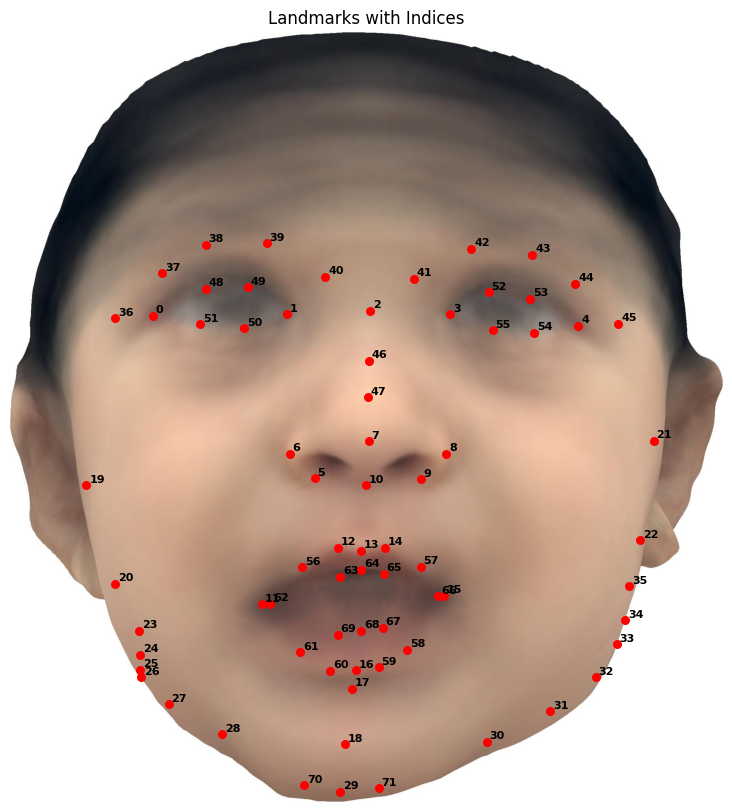

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_landmarks(image_path, keypoints_file, output_image_path=None, show_names=True):
    """
    Plot landmarks on an image with either their corresponding names or indices to help identify each landmark position.
    
    Args:
        image_path (str): Path to the image file.
        keypoints_file (str): Path to the keypoints file (.txt) containing landmark coordinates.
        output_image_path (str, optional): Path to save the output image with labeled landmarks.
                                           If not provided, the image will not be saved.
        show_names (bool, optional): If True, show landmark names. If False, show indices.
    """
    # List of landmark names
    landmark_names = [
        'exR', 'enR', 'n', 'enL', 'exL', 'acR', 'aR', 'prn', 'aL', 'acL', 'sn',
        'chR', 'cphR', 'ls', 'cphL', 'chL', 'li', 'sl', 'pg', 'tR', 'oiR', 'tL', 'oiL',
        'faceO_23', 'faceO_24', 'faceO_25', 'faceO_26', 'faceO_27', 
        'faceO_28', 'chin_29', 'faceO_30', 'faceO_31', 'faceO_32', 
        'faceO_33', 'faceO_34', 'faceO_35', 'rightEB_36', 'rightEB_37', 
        'rightEB_38', 'rightEB_39', 'rightEB_40', 'leftEB_41', 
        'leftEB_42', 'leftEB_43', 'leftEB_44', 'leftEB_45', 'nose_46', 
        'nose_47', 'rightE_48', 'rightE_49', 'rightE_50', 'rightE_51', 'leftE_52', 
        'leftE_53', 'leftE_54', 'leftE_55', 'upperL_56', 'upperL_57', 'lowerL_58', 
        'lowerL_59', 'lowerL_60', 'lowerL_61', 'lipE_62', 'upperL_63', 'upperL_64', 
        'upperL_65', 'lipE_66', 'lowerL_67', 'lowerL_68', 'lowerL_69', 'chin_70', 'chin_71'
    ]

    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the keypoints from the file
    with open(keypoints_file, 'r') as f:
        keypoints_data = f.readline().strip().split()

        # Check if the format is: class_idx cx cy w h x1 y1 ... xn yn
        if len(keypoints_data) == 149:  # 1 class_idx + 4 bbox values + 144 landmark values
            keypoints = np.array(keypoints_data[5:], dtype=np.float32).reshape(-1, 2)  # Ignoring class_idx and bbox
        else:  # Format is: class_idx x1 y1 ... xn yn
            keypoints = np.array(keypoints_data[1:], dtype=np.float32).reshape(-1, 2)  # Ignoring class_idx

    # Adjust figure size for better visibility
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    
    # Plot landmarks and label them with either names or indices
    for idx, (x, y) in enumerate(keypoints):
        x_pixel = int(x * image.shape[1])  # Denormalize the x-coordinate to image scale
        y_pixel = int(y * image.shape[0])  # Denormalize the y-coordinate to image scale
        plt.scatter(x_pixel, y_pixel, color='red', s=30)

        # Offset the text position slightly to avoid overlap with the points
        offset = 8
        if show_names:
            plt.text(x_pixel + offset, y_pixel - offset, landmark_names[idx], fontsize=8, color='black', fontweight='bold')
        else:
            plt.text(x_pixel + offset, y_pixel - offset, str(idx), fontsize=8, color='black', fontweight='bold')

    plt.title('Landmarks with Names' if show_names else 'Landmarks with Indices')
    plt.axis('off')

    # Save the image if output path is provided
    if output_image_path:
        plt.savefig(output_image_path)
    
    # Show the plot
    plt.show()



# Example usage
image_path = "/Users/jocareher/Downloads/synthetic_lmks_dataset/train/images/synthetic_shape_00002_frontal.jpg"
keypoints_file = "/Users/jocareher/Downloads/synthetic_lmks_dataset/train/labels/synthetic_shape_00002_frontal.txt"
output_image_path = "/Users/jocareher/Downloads/labeled_frontal_n.jpg"  # Optional, can be None

plot_landmarks(image_path, keypoints_file, output_image_path, show_names=False)


In [83]:
import os
import numpy as np
import matplotlib.pyplot as plt

def calculate_nme_intraocular_per_class(groundtruth_dir, predictions_dir):
    """
    Calculate the Normalized Mean Error (NME) using the intraocular distance for normalization
    and accumulate errors per class.
    
    Args:
        groundtruth_dir (str): Path to the directory containing groundtruth keypoints.
        predictions_dir (str): Path to the directory containing predicted keypoints.

    Returns:
        nme_per_class (dict): Dictionary where keys are class_idx and values are lists of NME per landmark.
        landmark_errors_per_class (dict): Dictionary where keys are class_idx and values are
                                          lists of NME for each landmark.
        overall_landmark_errors (list): List of NME values for each landmark across all images (for overall plot).
    """
    groundtruth_files = sorted(os.listdir(groundtruth_dir))
    prediction_files = sorted(os.listdir(predictions_dir))

    # Initialize dictionaries and lists to store NME for each class
    nme_per_class = {i: [] for i in range(5)}  # Assuming class_idx is between 0 and 4
    landmark_errors_per_class = {i: [[] for _ in range(72)] for i in range(5)}  # Assuming 72 landmarks
    overall_landmark_errors = [[] for _ in range(72)]  # For general boxplot

    # Landmarks around the eyes (using 0-based indices)
    left_eye_indices = [0, 1, 48, 49, 50, 51]  # Left eye landmarks
    right_eye_indices = [3, 4, 52, 53, 54, 55]  # Right eye landmarks

    # Loop through all groundtruth and prediction files
    for gt_file, pred_file in zip(groundtruth_files, prediction_files):
        gt_path = os.path.join(groundtruth_dir, gt_file)
        pred_path = os.path.join(predictions_dir, pred_file)

        try:
            # Load groundtruth and predictions
            with open(gt_path, 'r') as f_gt:
                gt_data = f_gt.readline().strip().split()
                class_idx = int(gt_data[0])  # Extract class_idx from groundtruth
                gt_keypoints = np.array(gt_data[5:], dtype=np.float32).reshape(-1, 3)[:, :2]  # Ignore bbox and visibility

            with open(pred_path, 'r') as f_pred:
                pred_data = f_pred.readline().strip().split()
                pred_keypoints = np.array(pred_data[1:], dtype=np.float32).reshape(-1, 3)[:, :2]  # Ignore class_idx and visibility

            # Check if the number of landmarks matches
            if gt_keypoints.shape != pred_keypoints.shape:
                if gt_keypoints.shape[0] > 72:
                    gt_keypoints = gt_keypoints[:72]
                if pred_keypoints.shape[0] > 72:
                    pred_keypoints = pred_keypoints[:72]
                if gt_keypoints.shape[0] < 72 or pred_keypoints.shape[0] < 72:
                    continue

            # Calculate the centroid of the eyes
            left_eye_center = np.mean(gt_keypoints[left_eye_indices], axis=0)
            right_eye_center = np.mean(gt_keypoints[right_eye_indices], axis=0)

            # Calculate intraocular distance
            intraocular_distance = np.linalg.norm(left_eye_center - right_eye_center)

            # Calculate NME for each landmark
            errors = np.linalg.norm(gt_keypoints - pred_keypoints, axis=1) / intraocular_distance

            # Accumulate errors for the corresponding class
            for i, error in enumerate(errors):
                landmark_errors_per_class[class_idx][i].append(error)
                overall_landmark_errors[i].append(error)  # Also accumulate for general plot

        except Exception as e:
            print(f"Error processing {gt_file}: {e}")
            continue

    # Calculate the mean NME per class
    for class_idx, errors in landmark_errors_per_class.items():
        nme_per_class[class_idx] = [np.mean(landmark_error) for landmark_error in errors]

    return nme_per_class, landmark_errors_per_class, overall_landmark_errors



import matplotlib.pyplot as plt
import numpy as np

def plot_landmark_error_boxplot_per_class(landmark_errors_per_class, overall_landmark_errors, output_image_path=None, show_names=True):
    """
    Plot boxplots of the Normalized Mean Error (NME) per class and overall using a logarithmic scale.

    Args:
        landmark_errors_per_class (dict): Dictionary where keys are class_idx and values are lists of NME per landmark.
        overall_landmark_errors (list): List of NME values for each landmark across all images.
        output_image_path (str, optional): Path to save the boxplot images.
        show_names (bool, optional): If True, display landmark names. If False, display indices.
    """
    epsilon = 1e-9  # Small value to avoid log(0)

    # List of landmark names
    landmark_names = [
        'exR', 'enR', 'n', 'enL', 'exL', 'acR', 'aR', 'prn', 'aL', 'acL', 'sn',
        'chR', 'cphR', 'ls', 'cphL', 'chL', 'li', 'sl', 'pg', 'tR', 'oiR', 'tL', 'oiL',
        'faceO_23', 'faceO_24', 'faceO_25', 'faceO_26', 'faceO_27', 
        'faceO_28', 'chin_29', 'faceO_30', 'faceO_31', 'faceO_32', 
        'faceO_33', 'faceO_34', 'faceO_35', 'rightEB_36', 'rightEB_37', 
        'rightEB_38', 'rightEB_39', 'rightEB_40', 'leftEB_41', 
        'leftEB_42', 'leftEB_43', 'leftEB_44', 'leftEB_45', 'nose_46', 
        'nose_47', 'rightE_48', 'rightE_49', 'rightE_50', 'rightE_51', 'leftE_52',
        'leftE_53', 'leftE_54', 'leftE_55', 'upperL_56', 'upperL_57', 'lowerL_58', 
        'lowerL_59', 'lowerL_60', 'lowerL_61', 'lipE_62', 'upperL_63', 'upperL_64', 
        'upperL_65', 'lipE_66', 'lowerL_67', 'lowerL_68', 'lowerL_69', 'chin_70', 'chin_71'
    ]

    # Plot boxplots for each class using a logarithmic y-scale
    for class_idx, landmark_errors in landmark_errors_per_class.items():
        # Add epsilon to avoid log(0)
        landmark_errors = [[max(e, epsilon) for e in lm_errors] for lm_errors in landmark_errors]

        plt.figure(figsize=(20, 8))  # Set figure size

        # Create the boxplot
        plt.boxplot(landmark_errors, showfliers=True, patch_artist=True,
                    boxprops=dict(facecolor="lightblue", color="blue"),
                    medianprops=dict(color="orange", linewidth=2),
                    whiskerprops=dict(color="black"),
                    flierprops=dict(marker='o', color='red', alpha=0.5))

        plt.xlabel("Landmarks", fontsize=12)
        plt.ylabel("NME (Log Scale)", fontsize=12)
        plt.title(f"NME per Landmark - Class {class_idx} (Log Scale)", fontsize=14)

        # Set y-axis to logarithmic scale
        plt.yscale("log")

        # Show landmark names or indices
        if show_names:
            plt.xticks(ticks=np.arange(1, 73, 1), labels=landmark_names, rotation=90, ha='right')
        else:
            plt.xticks(ticks=np.arange(1, 73, 1), labels=[f'LM_{i}' for i in range(0, 72)], rotation=90, ha='right')
        
        # Add grid for better visualization
        plt.grid(True, linestyle='--', alpha=0.7)

        # Save the plot if an output path is provided
        if output_image_path:
            plt.savefig(f"{output_image_path}_class_{class_idx}_log.png", bbox_inches="tight")

        plt.show()

    # Plot general boxplot (all classes combined) using a logarithmic y-scale
    overall_landmark_errors = [[max(e, epsilon) for e in lm_errors] for lm_errors in overall_landmark_errors]

    plt.figure(figsize=(20, 8))
    plt.boxplot(overall_landmark_errors, showfliers=True, patch_artist=True,
                boxprops=dict(facecolor="lightblue", color="blue"),
                medianprops=dict(color="orange", linewidth=2),
                whiskerprops=dict(color="black"),
                flierprops=dict(marker='o', color='red', alpha=0.5))

    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title("NME per Landmark - Overall (Log Scale)", fontsize=14)

    # Set y-axis to logarithmic scale
    plt.yscale("log")

    # Show landmark names or indices
    if show_names:
        plt.xticks(ticks=np.arange(1, 73, 1), labels=landmark_names, rotation=90, ha='right')
    else:
        plt.xticks(ticks=np.arange(1, 73, 1), labels=[f'LM_{i}' for i in range(0, 72)], rotation=90, ha='right')
    
    # Add grid for better visualization
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the plot if an output path is provided
    if output_image_path:
        plt.savefig(f"{output_image_path}_overall_log.png", bbox_inches="tight")

    plt.show()


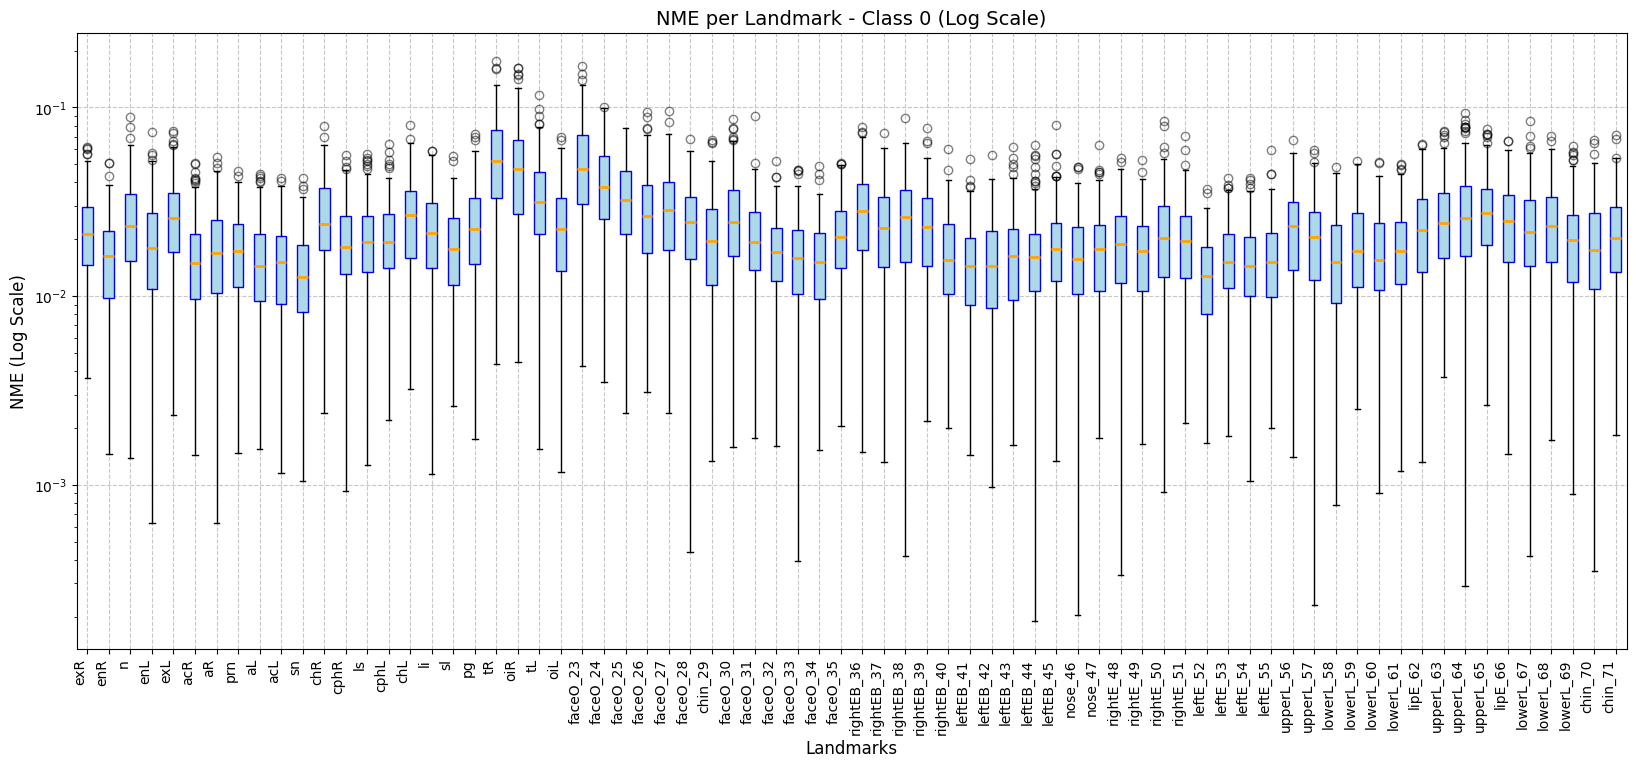

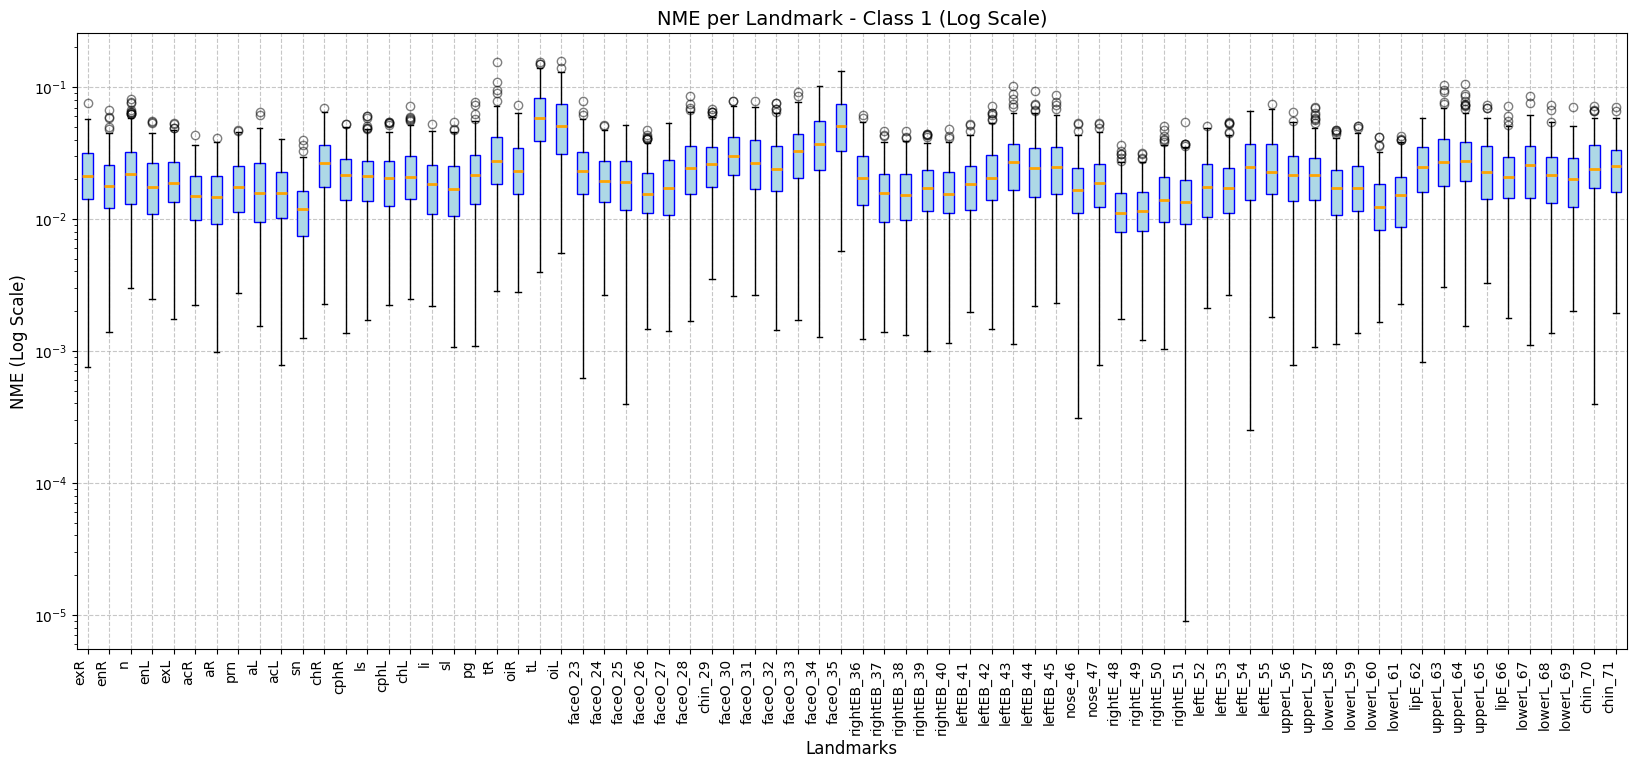

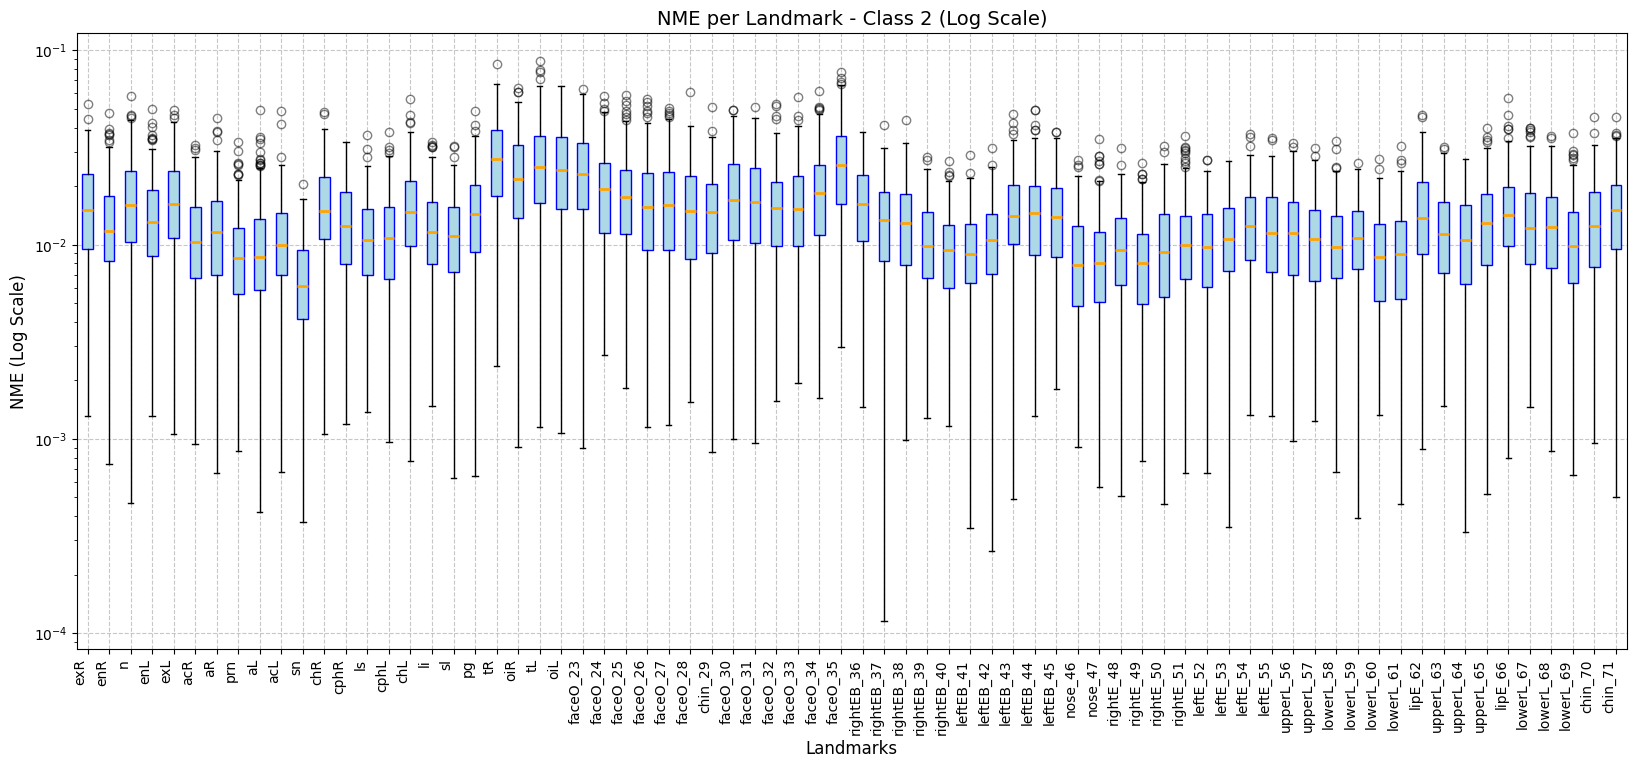

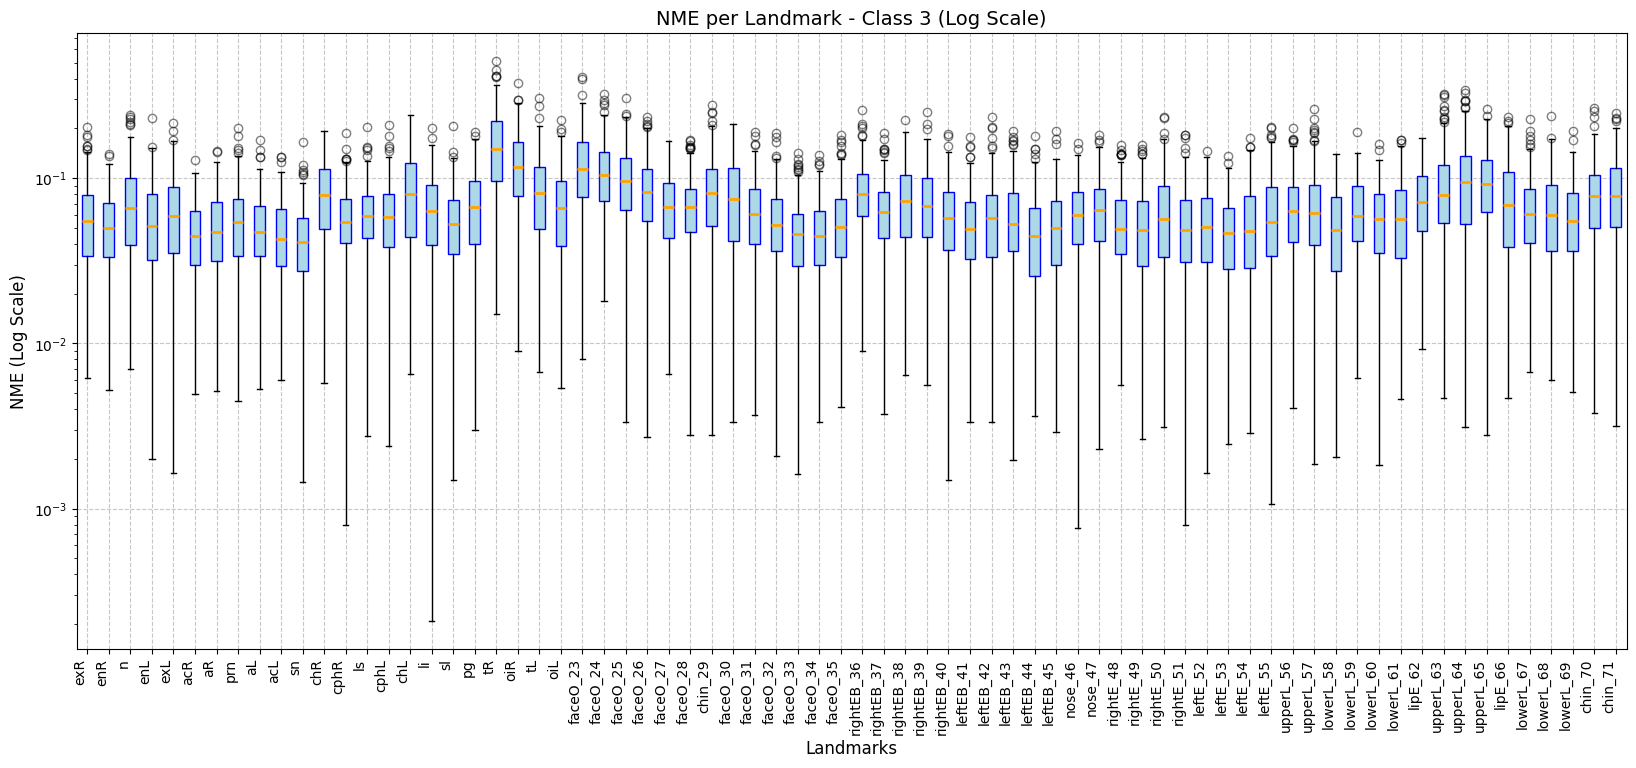

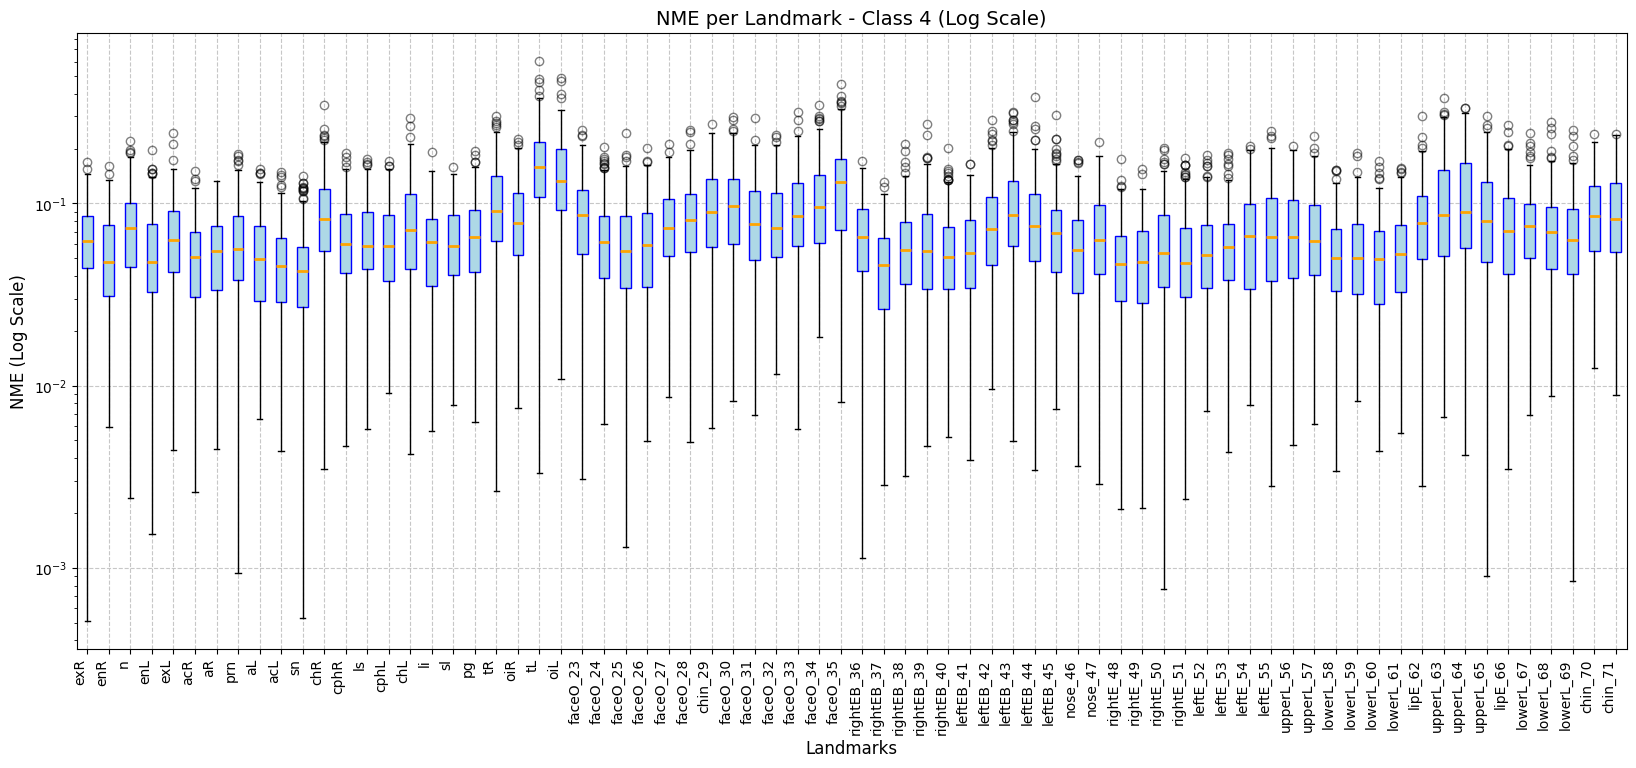

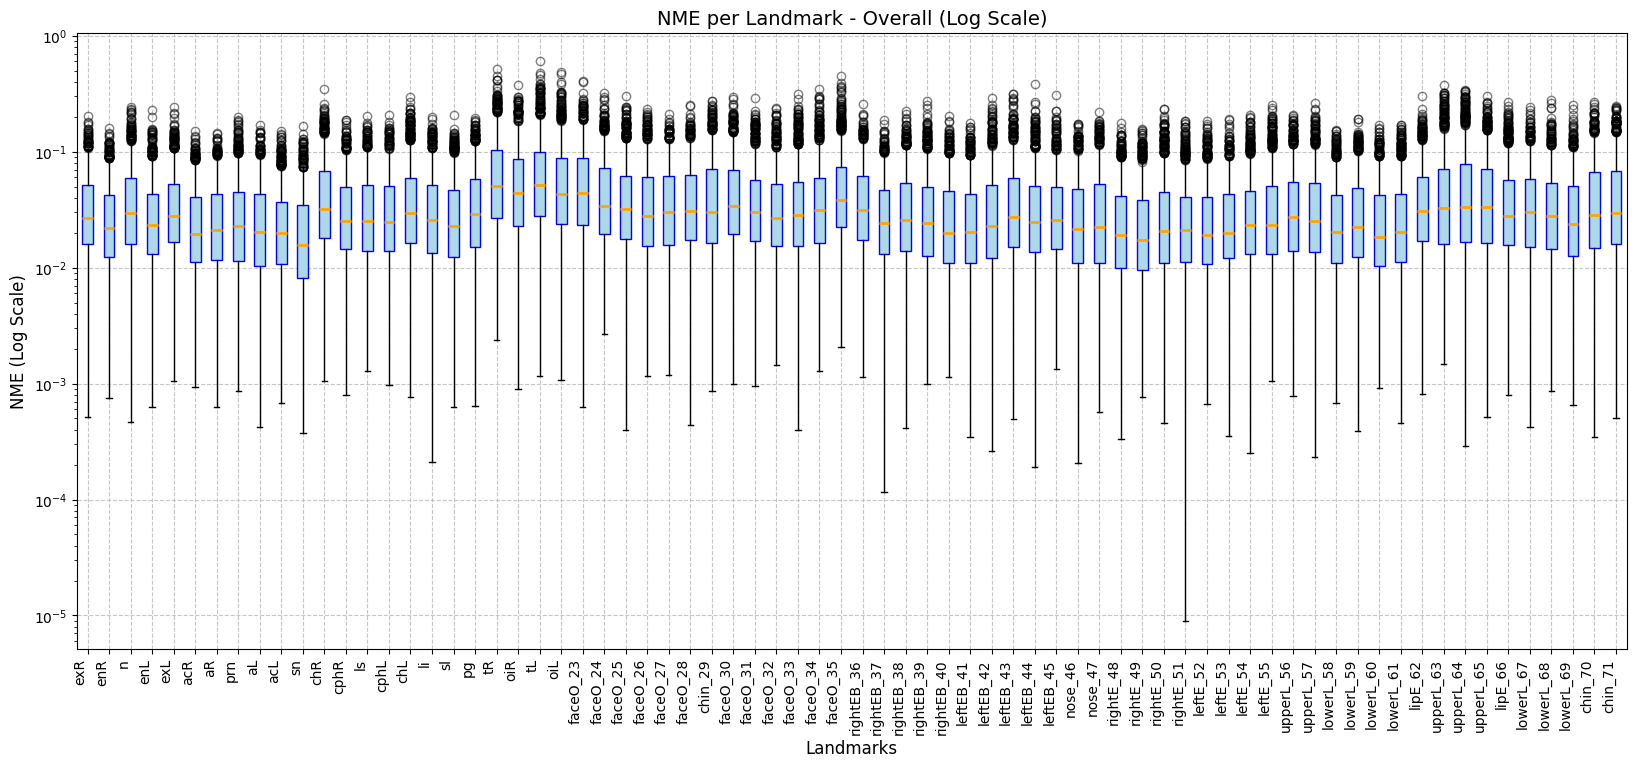

In [89]:
# Paths for groundtruth and prediction directories
groundtruth_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/labels"  # Example path to groundtruth
predictions_dir = "/Users/jocareher/Downloads/pred_model_fixed/labels"  # "/Users/jocareher/Downloads/pose_pred_vis/labels"
nme_per_class, landmark_errors_per_class, overall_landmark_errors = calculate_nme_intraocular_per_class(groundtruth_dir, predictions_dir)
plot_landmark_error_boxplot_per_class(landmark_errors_per_class, overall_landmark_errors, output_image_path="nme_boxplot", show_names=True)


In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def generate_confusion_matrices_with_metrics(groundtruth_dir, predictions_dir, output_dir=None, threshold=0.5):
    """
    Generate confusion matrices with detailed metrics for visibility predictions per class and overall.

    Args:
        groundtruth_dir (str): Path to the directory containing groundtruth files.
        predictions_dir (str): Path to the directory containing predicted files.
        output_dir (str, optional): Path to save the confusion matrix plots.
        threshold (float): Confidence threshold to classify predictions as visible or occluded.

    Returns:
        dict: Confusion matrices and classification reports for each class and overall.
    """
    groundtruth_files = sorted(os.listdir(groundtruth_dir))
    prediction_files = sorted(os.listdir(predictions_dir))

    class_metrics = {}
    overall_groundtruth = []
    overall_predictions = []

    for class_idx in range(5):
        gt_labels = []
        pred_labels = []

        for gt_file, pred_file in zip(groundtruth_files, prediction_files):
            gt_path = os.path.join(groundtruth_dir, gt_file)
            pred_path = os.path.join(predictions_dir, pred_file)

            with open(gt_path, 'r') as f_gt, open(pred_path, 'r') as f_pred:
                gt_data = f_gt.readline().strip().split()
                pred_data = f_pred.readline().strip().split()

                if int(gt_data[0]) != class_idx:
                    continue  # Skip files not belonging to the current class

                # Extract visibility labels
                gt_visibilities = np.array(gt_data[5:], dtype=np.float32).reshape(-1, 3)[:, 2]
                pred_confidences = np.array(pred_data[1:], dtype=np.float32).reshape(-1, 3)[:, 2]

                # Convert confidences to binary predictions
                gt_binary = (gt_visibilities == 2).astype(int)  # 2 = visible, 1 = occluded
                pred_binary = (pred_confidences >= threshold).astype(int)

                gt_labels.extend(gt_binary)
                pred_labels.extend(pred_binary)

                # Accumulate for overall confusion matrix
                overall_groundtruth.extend(gt_binary)
                overall_predictions.extend(pred_binary)

        # Compute confusion matrix and metrics
        cm = confusion_matrix(gt_labels, pred_labels)
        report = classification_report(gt_labels, pred_labels, target_names=["Occluded", "Visible"], digits=2)
        class_metrics[class_idx] = {
            "confusion_matrix": cm,
            "classification_report": report
        }

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(6, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Occluded", "Visible"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        plt.title(f"Confusion Matrix - Class {class_idx}")
        plt.grid(False)

        # Save the plot if output directory is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"confusion_matrix_class_{class_idx}.png"), bbox_inches="tight")

        plt.show()

        # Print metrics to console
        print(f"\nMetrics for Class {class_idx}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

    # Compute overall confusion matrix and metrics
    overall_cm = confusion_matrix(overall_groundtruth, overall_predictions)
    overall_report = classification_report(overall_groundtruth, overall_predictions, target_names=["Occluded", "Visible"], digits=2)
    class_metrics["overall"] = {
        "confusion_matrix": overall_cm,
        "classification_report": overall_report
    }

    # Plot overall confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm, display_labels=["Occluded", "Visible"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix - Overall")
    plt.grid(False)

    if output_dir:
        plt.savefig(os.path.join(output_dir, "confusion_matrix_overall.png"), bbox_inches="tight")

    plt.show()

    # Print overall metrics to console
    print("\nOverall Metrics:")
    print(f"Confusion Matrix:\n{overall_cm}")
    print(f"Classification Report:\n{overall_report}")

    return class_metrics

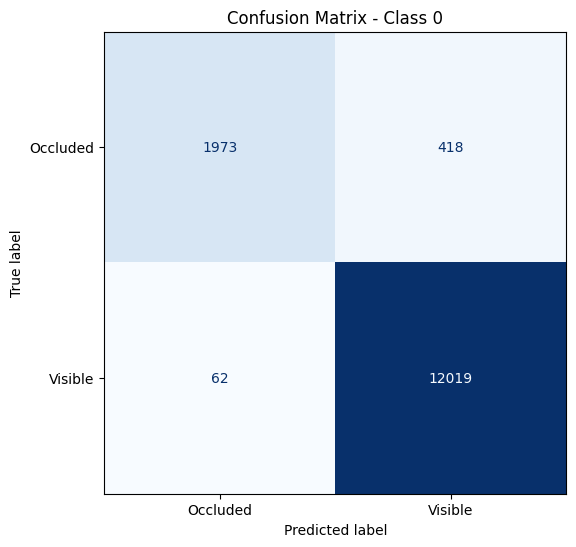


Metrics for Class 0:
Confusion Matrix:
[[ 1973   418]
 [   62 12019]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.97      0.83      0.89      2391
     Visible       0.97      0.99      0.98     12081

    accuracy                           0.97     14472
   macro avg       0.97      0.91      0.94     14472
weighted avg       0.97      0.97      0.97     14472



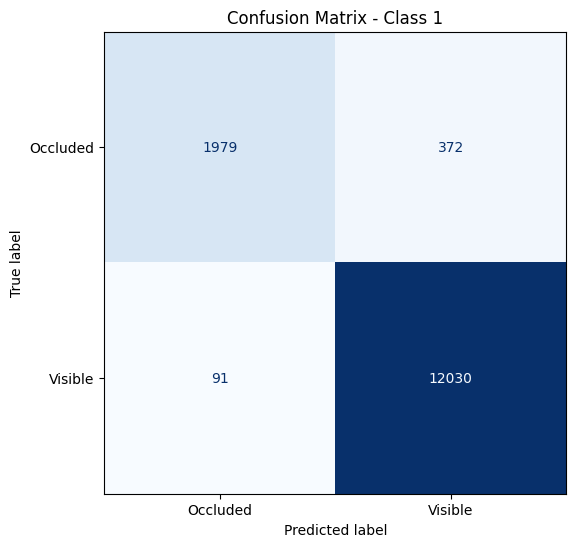


Metrics for Class 1:
Confusion Matrix:
[[ 1979   372]
 [   91 12030]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.96      0.84      0.90      2351
     Visible       0.97      0.99      0.98     12121

    accuracy                           0.97     14472
   macro avg       0.96      0.92      0.94     14472
weighted avg       0.97      0.97      0.97     14472



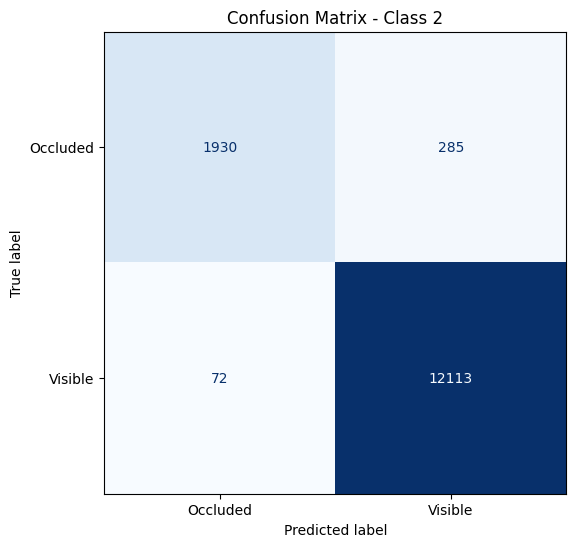


Metrics for Class 2:
Confusion Matrix:
[[ 1930   285]
 [   72 12113]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.96      0.87      0.92      2215
     Visible       0.98      0.99      0.99     12185

    accuracy                           0.98     14400
   macro avg       0.97      0.93      0.95     14400
weighted avg       0.98      0.98      0.97     14400



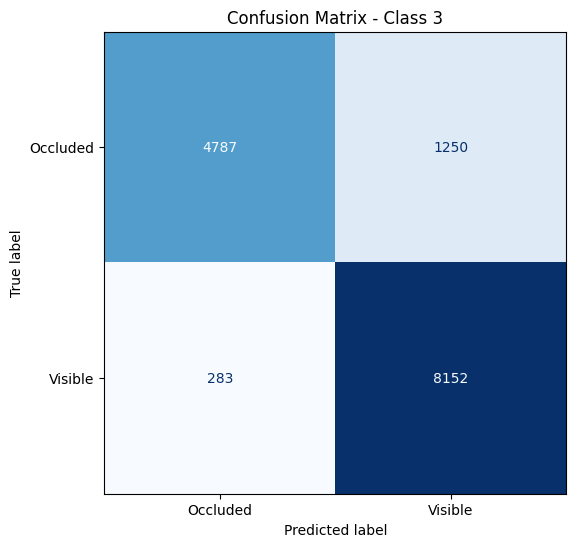


Metrics for Class 3:
Confusion Matrix:
[[4787 1250]
 [ 283 8152]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.94      0.79      0.86      6037
     Visible       0.87      0.97      0.91      8435

    accuracy                           0.89     14472
   macro avg       0.91      0.88      0.89     14472
weighted avg       0.90      0.89      0.89     14472



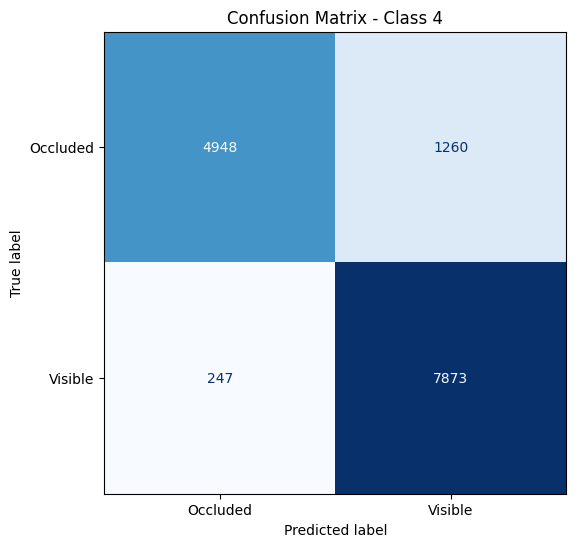


Metrics for Class 4:
Confusion Matrix:
[[4948 1260]
 [ 247 7873]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.95      0.80      0.87      6208
     Visible       0.86      0.97      0.91      8120

    accuracy                           0.89     14328
   macro avg       0.91      0.88      0.89     14328
weighted avg       0.90      0.89      0.89     14328



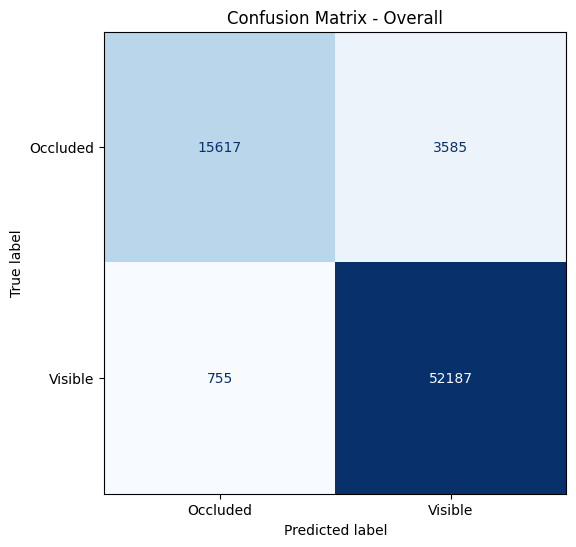


Overall Metrics:
Confusion Matrix:
[[15617  3585]
 [  755 52187]]
Classification Report:
              precision    recall  f1-score   support

    Occluded       0.95      0.81      0.88     19202
     Visible       0.94      0.99      0.96     52942

    accuracy                           0.94     72144
   macro avg       0.94      0.90      0.92     72144
weighted avg       0.94      0.94      0.94     72144



In [90]:
groundtruth_dir = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset/test/labels"  # Example path to groundtruth
predictions_dir = "/Users/jocareher/Downloads/pred_model_fixed/labels" 
output_dir = "/Users/jocareher/Downloads"  # Optional

results = generate_confusion_matrices_with_metrics(groundtruth_dir, predictions_dir, output_dir)

In [2]:
import numpy as np
import cv2
import os
from ultralytics import YOLO

def plot_keypoints(image, keypoints, output_path):
    """
    Plots keypoints on the image and saves the result. Keypoints with visibility below 0.5 are blue, 
    while those above 0.5 are red.

    Args:
        image (numpy.ndarray): The input image.
        keypoints (numpy.ndarray): Keypoints in pixel coordinates with visibility (x, y, visibility).
        output_path (str): The path to save the image with plotted keypoints.
    """
    # Calculate the diagonal of the image to determine proportional landmark size
    height, width, _ = image.shape
    image_diagonal = (width**2 + height**2) ** 0.5

    # Calculate dynamic radius for the keypoints
    radius = max(int(image_diagonal * 0.0025), 1)  # Minimum radius of 1
    thickness = -1  # Fill the circles

    for (x, y, v) in keypoints:
        x, y = int(x), int(y)
        color = (255, 0, 0) if v < 0.5 else (0, 0, 255)  # Blue if visibility < 0.5, Red otherwise
        cv2.circle(image, (x, y), radius, color, thickness)  # Draw keypoint

    # Save the image with keypoints
    cv2.imwrite(output_path, image)
    


def run_pipeline(input_dir, output_dir, face_model_path, landmark_model_path, imgsz=640, conf=0.50):
    """
    Integrate face detection and landmark detection into a single pipeline.
    """
    # Load models
    face_model = YOLO(face_model_path)
    landmark_model = YOLO(landmark_model_path)

    # Ensure output directories exist
    labels_dir = os.path.join(output_dir, 'labels')
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)

    # Get list of image files
    image_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

    total_faces_detected = 0
    total_faces_not_detected = 0
    total_faces_with_landmarks = 0
    total_faces_without_landmarks = 0

    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)

        if not os.path.isfile(image_path):
            continue

        # Detect faces using OBBabyFace model
        face_results = face_model.predict(source=image_path, imgsz=640, conf=conf, save=False)

        # Load the original image
        image = cv2.imread(image_path)
        height, width, _ = image.shape

        base_filename = os.path.splitext(image_file)[0]

        # Initialize output label file
        output_label_file_path = os.path.join(labels_dir, f"{base_filename}.txt")
        face_detected = False

        with open(output_label_file_path, 'w') as label_file:
            for face_result in face_results:
                if face_result.obb is None or len(face_result.obb) == 0:
                    continue

                for obb in face_result.obb:  # Process each OBB
                    try:
                        face_detected = True
                        total_faces_detected += 1

                        # Extract OBB coordinates
                        obb_coords = obb.xyxyxyxyn.cpu().numpy().flatten()  # Get normalized OBB coordinates

                        # Convert OBB to image space (denormalize coordinates)
                        obb_coords = obb_coords * np.array([width, height] * 4)  # Scale to image dimensions
                        obb_coords = obb_coords.reshape(4, 2).astype(int)  # Reshape to 4x2 array

                        # Create a mask for the OBB
                        mask = np.zeros((height, width), dtype=np.uint8)
                        cv2.fillPoly(mask, [obb_coords], 255)

                        # Crop the face using the OBB mask
                        face_cropped = cv2.bitwise_and(image, image, mask=mask)
                        x, y, w, h = cv2.boundingRect(obb_coords)  # Get bounding box to crop region of interest
                        face_cropped = face_cropped[y:y + h, x:x + w]

                        # Run landmark detection on the cropped face
                        landmark_results = landmark_model.predict(source=face_cropped, imgsz=imgsz, conf=conf, save=False)
                        landmarks_detected = False

                        best_confidence = -1
                        best_keypoints_xyn = None
                        best_visibility = None
                        best_class_idx = None

                        for landmark_result in landmark_results:
                            if landmark_result.keypoints is None or len(landmark_result.keypoints) == 0:
                                continue

                            keypoints_xyn = landmark_result.keypoints.xyn.cpu().numpy()
                            visibility = landmark_result.keypoints.conf.cpu().numpy()

                            # Handle dimensions for multiple detections
                            if keypoints_xyn.ndim == 3 and keypoints_xyn.shape[0] > 1:
                                for i in range(keypoints_xyn.shape[0]):
                                    current_visibility = visibility[i]
                                    current_confidence = np.mean(current_visibility)  # Mean confidence for this set
                                    if current_confidence > best_confidence:
                                        best_confidence = current_confidence
                                        best_keypoints_xyn = keypoints_xyn[i]
                                        best_visibility = current_visibility
                                        best_class_idx = int(landmark_result.boxes.cls.cpu().numpy()[i])
                            elif keypoints_xyn.ndim == 3 and keypoints_xyn.shape[0] == 1:
                                keypoints_xyn = keypoints_xyn.squeeze(0)  # Remove extra dimension
                                current_confidence = np.mean(visibility)
                                if current_confidence > best_confidence:
                                    best_confidence = current_confidence
                                    best_keypoints_xyn = keypoints_xyn
                                    best_visibility = visibility
                                    best_class_idx = int(landmark_result.boxes.cls.cpu().numpy()[0])
                            elif keypoints_xyn.ndim == 2:
                                current_confidence = np.mean(visibility)
                                if current_confidence > best_confidence:
                                    best_confidence = current_confidence
                                    best_keypoints_xyn = keypoints_xyn
                                    best_visibility = visibility
                                    best_class_idx = int(landmark_result.boxes.cls.cpu().numpy()[0])
                            else:
                                print(f"Unexpected shape of keypoints_xyn: {keypoints_xyn.shape}. Skipping.")
                                continue

                        if best_keypoints_xyn is not None:
                            landmarks_detected = True

                            # Ensure visibility length matches keypoints length
                            best_visibility = best_visibility[:best_keypoints_xyn.shape[0]]

                            # Step 1: Convert keypoints to pixel space of cropped face
                            cropped_width = face_cropped.shape[1]
                            cropped_height = face_cropped.shape[0]
                            keypoints_pixel = best_keypoints_xyn[:, :2] * np.array([cropped_width, cropped_height])

                            # Step 2: Translate keypoints to global image space
                            keypoints_global = keypoints_pixel + np.array([x, y])

                            # Step 3: Concatenate visibility values
                            keypoints_with_visibility = np.hstack((keypoints_global, best_visibility.reshape(-1, 1)))

                            # Flatten keypoints for saving
                            flattened_keypoints = keypoints_with_visibility.flatten()
                            label_file.write(f"{best_class_idx} {' '.join(map(str, flattened_keypoints))}\n")

                            # Draw keypoints on the original image
                            output_image_path = os.path.join(images_dir, image_file)
                            plot_keypoints(image, keypoints_with_visibility, output_image_path)

                        if landmarks_detected:
                            total_faces_with_landmarks += 1
                        else:
                            total_faces_without_landmarks += 1

                        # Save the OBB for the face as part of the labels
                        obb_coords_normalized = obb.xyxyxyxyn.cpu().numpy().flatten()  # Keep OBB in normalized format
                        label_file.write(f"Face_OBB {' '.join(map(str, obb_coords_normalized))}\n")

                    except Exception as e:
                        print(f"Error processing OBB for {image_file}: {e}")

        if not face_detected:
            total_faces_not_detected += 1

    # Print summary
    print(f"\nPipeline Summary:")
    print(f"Total Images Processed: {len(image_files)}")
    print(f"Faces Detected: {total_faces_detected}")
    print(f"Faces Not Detected: {total_faces_not_detected}")
    print(f"Faces with Landmarks Detected: {total_faces_with_landmarks}")
    print(f"Faces without Landmarks Detected: {total_faces_without_landmarks}")

In [3]:
input_directory = "/Users/jocareher/Downloads/baby_face_72/images"
output_directory = "/Users/jocareher/Downloads/model_fixed_bf72"
face_model_path = "/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/models_weights/obbabyface_weights.pt"
landmark_model_path = "/Users/jocareher/Downloads/model_fixed/weights/best.pt"

run_pipeline(input_directory, output_directory, face_model_path, landmark_model_path, imgsz=640)


image 1/1 /Users/jocareher/Downloads/baby_face_72/images/face_bcn_00.JPG: 448x640 101.8ms
Speed: 2.5ms preprocess, 101.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is NOT included for each keypoint.
0: 608x640 (no detections), 172.8ms
Speed: 2.3ms preprocess, 172.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
Error processing OBB for face_bcn_00.JPG: 'NoneType' object has no attribute 'cpu'

image 1/1 /Users/jocareher/Downloads/baby_face_72/images/face_bcn_01.JPG: 448x640 97.6ms
Speed: 2.8ms preprocess, 97.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

Visibility flag is NOT included for each keypoint.
0: 640x608 (no detections), 150.3ms
Speed: 1.9ms preprocess, 150.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
Error processing OBB for face_bcn_01.JPG: 'NoneType' object has no attribute 'cpu'

image 1/1 /Users/jocareher/Downloads/baby_face_72/images/face_bcn_02.JPG: 448x640 112